## Parallel, Multi-Objective BO in BoTorch with qEHVI and qParEGO

In this tutorial, we illustrate how to implement a simple multi-objective (MO) Bayesian Optimization (BO) closed loop in BoTorch.

We use the parallel ParEGO ($q$ParEGO) [1] and parallel Expected Hypervolume Improvement ($q$EHVI) [1]  acquisition functions to optimize a  synthetic Branin-Currin test function. The two objectives are

$$f^{(1)}(x_1\text{'}, x_2\text{'}) = (x_2\text{'} - \frac{5.1}{4 \pi^ 2} (x_1\text{'})^2 + \frac{5}{\pi} x_1\text{'} - r)^2 + 10 (1-\frac{1}{8 \pi}) \cos(x_1\text{'}) + 10$$

$$f^{(2)}(x_1, x_2) = \bigg[1 - \exp\bigg(-\frac{1} {(2x_2)}\bigg)\bigg] \frac{2300 x_1^3 + 1900x_1^2 + 2092 x_1 + 60}{100 x_1^3 + 500x_1^2 + 4x_1 + 20}$$

where $x_1, x_2 \in [0,1]$, $x_1\text{'} = 15x_1 - 5$, and $x_2\text{'} = 15x_2$ (parameter values can be found in `botorch/test_functions/multi_objective.py`).

Since botorch assumes a maximization of all objectives, we seek to find the pareto frontier, the set of optimal trade-offs where improving one metric means deteriorating another.

[1] [Samuel Daulton, Maximillian Balandat, Eytan Bakshy. Differentiable Expected Hypervolume Improvement for Parallel Multi-Objective Bayesian Optimization. ArXiv e-prints, 2020.](https://arxiv.org/abs/2006.05078)

### Set dtype and device
Note: $q$EHVI aggressively exploits parallel hardware and is much faster when run on a GPU. See [1] for details.

In [2]:
import torch
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

### Problem setup


In [3]:
from botorch.test_functions.multi_objective import BraninCurrin

problem = BraninCurrin(negate=True).to(**tkwargs)

In [19]:
# transform objective to target (-9, -3)

def transform_objective(x):
    t = torch.zeros_like(x)
    upper = [1.0, -2.0]
    lower = [-19.0, -4.0]
    nrow, ncol = x.shape
    for i in range(nrow):
        for j in range(ncol):
            if x[i, j] <= upper[j] and x[i, j] >= lower[j]:
                t[i, j] = 1.0
            else:
                t[i, j] = 0.0
    return t

In [20]:
for i,j in problem(torch.tensor([[0.5, 0.5], [1, 1]])):
    if i < -100:
        print(i)

tensor(-145.8722)


In [21]:
transform_objective(problem(torch.tensor([[0.5, 0.5], [1, 1]])))

tensor([[0., 0.],
        [0., 0.]])

In [6]:
problem.ref_point

tensor([-18.,  -6.], dtype=torch.float64)

#### Model initialization

We use a multi-output `SingleTaskGP` to model the two objectives with a homoskedastic Gaussian likelihood with an inferred noise level.

The models are initialized with $2(d+1)=6$ points drawn randomly from $[0,1]^2$.

In [7]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import unnormalize
from botorch.utils.sampling import draw_sobol_samples

def generate_initial_data(n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=n, seed=torch.randint(1000000, (1,)).item()).squeeze(0)
    train_obj = transform_objective(problem(train_x))
    return train_x, train_obj
    
def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

#### Define a helper function that performs the essential BO step for $q$EHVI
The helper function below initializes the $q$EHVI acquisition function, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. 

For this example, we'll use a small batch of $q=4$. Passing the keyword argument `sequential=True` to the function `optimize_acqf`specifies that candidates should be optimized in a sequential greedy fashion (see [1] for details why this is important). A simple initialization heuristic is used to select the 20 restart initial locations from a set of 1024 random points. Multi-start optimization of the acquisition function is performed using LBFGS-B with exact gradients computed via auto-differentiation.

**Reference Point**

$q$EHVI requires specifying a reference point, which is the lower bound on the objectives used for computing hypervolume. In this tutorial, we assume the reference point is known. In practice the reference point can be set 1) using domain knowledge to be slightly worse than the lower bound of objective values, where the lower bound is the minimum acceptable value of interest for each objective, or 2) using a dynamic reference point selection strategy.

**Partitioning the Non-dominated Space into disjoint rectangles**

$q$EHVI requires partitioning the non-dominated space into disjoint rectangles (see [1] for details). 

*Note:* `NondominatedPartitioning` *will be very slow when 1) there are a lot of points on the pareto frontier and 2) there are >3 objectives.*

In [8]:
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decomposition import NondominatedPartitioning
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.utils.sampling import sample_simplex

BATCH_SIZE = 4
standard_bounds = torch.zeros(2, problem.dim, **tkwargs)
standard_bounds[1] = 1


def optimize_qehvi_and_get_observation(model, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    partitioning = NondominatedPartitioning(num_outcomes=problem.num_objectives, Y=train_obj)
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=[-3, -1],  # use known reference point 
        partitioning=partitioning,
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=20,
        raw_samples=1024,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200, "nonnegative": True},
        sequential=True,
    )
    # observe new values 
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj = transform_objective(problem(new_x))
    return new_x, new_obj

#### Define a helper function that performs the essential BO step for $q$ParEGO
The helper function below similarly initializes $q$ParEGO, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. 

$q$ParEGO uses random augmented chebyshev scalarization with the `qExpectedImprovement` acquisition function. In the parallel setting ($q>1$), each candidate is optimized in sequential greedy fashion using a different random scalarization (see [1] for details).

To do this, we create a list of `qExpectedImprovement` acquisition functions, each with different random scalarization weights. The `optimize_acqf_list` method sequentially generates one candidate per acquisition function and conditions the next candidate (and acquisition function) on the previously selected pending candidates.

In [9]:
def optimize_qparego_and_get_observation(model, train_obj, sampler):
    """Samples a set of random weights for each candidate in the batch, performs sequential greedy optimization 
    of the qParEGO acquisition function, and returns a new candidate and observation."""
    acq_func_list = []
    for _ in range(BATCH_SIZE):
        weights = sample_simplex(problem.num_objectives, **tkwargs).squeeze()
        objective = GenericMCObjective(get_chebyshev_scalarization(weights=weights, Y=train_obj))
        acq_func = qExpectedImprovement(  # pyre-ignore: [28]
            model=model,
            objective=objective,
            best_f=objective(train_obj).max().item(),
            sampler=sampler,
        )
        acq_func_list.append(acq_func)
    # optimize
    candidates, _ = optimize_acqf_list(
        acq_function_list=acq_func_list,
        bounds=standard_bounds,
        num_restarts=20,
        raw_samples=1024,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values 
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj = transform_objective(problem(new_x))
    return new_x, new_obj

### Perform Bayesian Optimization loop with $q$EHVI and $q$ParEGO
The Bayesian optimization "loop" for a batch size of $q$ simply iterates the following steps:
1. given a surrogate model, choose a batch of points $\{x_1, x_2, \ldots x_q\}$
2. observe $f(x)$ for each $x$ in the batch 
3. update the surrogate model. 


Just for illustration purposes, we run three trials each of which do `N_BATCH=25` rounds of optimization. The acquisition function is approximated using `MC_SAMPLES=128` samples.

*Note*: Running this may take a little while.

In [10]:
from botorch import fit_gpytorch_model
from botorch.optim.fit import fit_gpytorch_torch
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
import time

import warnings
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

N_TRIALS = 3
N_BATCH = 25
MC_SAMPLES = 128

verbose = False

hvs_qparego_all, hvs_qehvi_all, hvs_random_all = [], [], []

hv = Hypervolume(ref_point=torch.tensor([-10.0, -1.0]))

# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    torch.manual_seed(trial)
    
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    hvs_qparego, hvs_qehvi, hvs_random = [], [], []
    
    # call helper functions to generate initial training data and initialize model
    train_x_qparego, train_obj_qparego = generate_initial_data(n=6)
    mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego)
    
    train_x_qehvi, train_obj_qehvi = train_x_qparego, train_obj_qparego
    train_x_random, train_obj_random = train_x_qparego, train_obj_qparego
    # compute hypervolume 
    mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)
    
    # compute pareto front
    pareto_mask = is_non_dominated(train_obj_qparego)
    pareto_y = train_obj_qparego[pareto_mask]
    # compute hypervolume
    
    volume = hv.compute(pareto_y)
    
    hvs_qparego.append(volume)
    hvs_qehvi.append(volume)
    hvs_random.append(volume)
    
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):    
        
        t0 = time.time()
        
        # fit the models
        fit_gpytorch_model(mll_qparego, optimizer=fit_gpytorch_torch)
        fit_gpytorch_model(mll_qehvi, optimizer=fit_gpytorch_torch)
        
        # define the qEI and qNEI acquisition modules using a QMC sampler
        qparego_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        qehvi_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        
        # optimize acquisition functions and get new observations
        new_x_qparego, new_obj_qparego = optimize_qparego_and_get_observation(
            model_qparego, train_obj_qparego, qparego_sampler
        )
        new_x_qehvi, new_obj_qehvi = optimize_qehvi_and_get_observation(
            model_qehvi, train_obj_qehvi, qehvi_sampler
        )
        new_x_random, new_obj_random = generate_initial_data(n=BATCH_SIZE)
                
        # update training points
        train_x_qparego = torch.cat([train_x_qparego, new_x_qparego])
        train_obj_qparego = torch.cat([train_obj_qparego, new_obj_qparego])

        train_x_qehvi = torch.cat([train_x_qehvi, new_x_qehvi])
        train_obj_qehvi = torch.cat([train_obj_qehvi, new_obj_qehvi])
    
        train_x_random = torch.cat([train_x_random, new_x_random])
        train_obj_random = torch.cat([train_obj_random, new_obj_random])
        

        # update progress
        for hvs_list, train_obj in zip(
            (hvs_random, hvs_qparego, hvs_qehvi), 
            (train_obj_random, train_obj_qparego, train_obj_qehvi),
        ):
            # compute pareto front
            pareto_mask = is_non_dominated(train_obj)
            pareto_y = train_obj[pareto_mask]
            # compute hypervolume
            volume = hv.compute(pareto_y)
            hvs_list.append(volume)

        # reinitialize the models so they are ready for fitting on next iteration
        # Note: we find improved performance from not warm starting the model hyperparameters
        # using the hyperparameters from the previous iteration
        mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego)
        mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)
        
        t1 = time.time()
        
        if verbose:
            print(
                f"\nBatch {iteration:>2}: Hypervolume (random, qParEGO, qEHVI) = "
                f"({hvs_random[-1]:>4.2f}, {hvs_qparego[-1]:>4.2f}, {hvs_qehvi[-1]:>4.2f}), "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")
   
    hvs_qparego_all.append(hvs_qparego)
    hvs_qehvi_all.append(hvs_qehvi)
    hvs_random_all.append(hvs_random)


Trial  1 of 3 Iter 10/100: 2.6160859589005327
Iter 20/100: 2.4531662523272413
Iter 30/100: 2.3238755833539506
Iter 40/100: 2.1017456886861554
Iter 10/100: 2.615533025184702
Iter 20/100: 2.4524721697450453
Iter 30/100: 2.3282608888569674
Iter 40/100: 2.139777272989797
Iter 10/100: 2.6160859589005327
Iter 20/100: 2.4531662523272413
Iter 30/100: 2.3238755833539506
Iter 40/100: 2.1017456886861554
Iter 10/100: 2.615533025184702
Iter 20/100: 2.4524721697450453
Iter 30/100: 2.3282608888569674
Iter 40/100: 2.139777272989797
.Iter 10/100: 2.1937642860738538
Iter 20/100: 2.075806791506711
Iter 30/100: 1.9631877356738283
Iter 40/100: 1.7760749710093964
Iter 10/100: 2.185214644047877
Iter 20/100: 2.0693872853049493
Iter 30/100: 1.959094872067719
Iter 40/100: 1.7927418759871774
Iter 10/100: 2.1902259319276682
Iter 20/100: 2.072171739577742
Iter 30/100: 1.9622727060779002
Iter 40/100: 1.7756687935813438
Iter 10/100: 2.18143958737834
Iter 20/100: 2.0607845650539827
Iter 30/100: 1.9471977476903457
It

Iter 100/100: -1.2956369208256981
Iter 10/100: 1.4938543538090423
Iter 20/100: 1.334087385013252
Iter 30/100: 1.0380393192532515
Iter 40/100: -0.5090850272393085
Iter 50/100: -0.8126755646133381
.Iter 10/100: 1.5038775538947144
Iter 20/100: 1.3433683397722753
Iter 30/100: 1.049461567030743
Iter 40/100: 0.4277579062381315
Iter 10/100: 1.4528287625202925
Iter 20/100: 1.2962011871628227
Iter 30/100: 1.0027408462430327
Iter 10/100: 1.4393770679540518
Iter 20/100: 1.2654139308536976
Iter 30/100: 0.9402360472800677
Iter 40/100: -1.1869802164753203
Iter 50/100: -1.2585452346967994
Iter 60/100: -1.2887591943860799
Iter 70/100: -1.3033476576981795
Iter 80/100: -1.3110728749647633
Iter 90/100: -1.315280781471971
Iter 100/100: -1.3181061638834168
Iter 10/100: 1.4826341057417662
Iter 20/100: 1.3219191973683078
Iter 30/100: 1.025513465734276
Iter 40/100: 0.5099863617991156
.Iter 10/100: 1.4888792259577677
Iter 20/100: 1.3252234348150236
Iter 30/100: 1.028920039356156
Iter 40/100: -0.462154236637641

Iter 80/100: -2.06973314725888
Iter 90/100: -2.0713422914264465
Iter 100/100: -2.072376223016748
Iter 10/100: 1.392993893095569
Iter 20/100: 1.2125700758219033
Iter 30/100: 0.8744286241465603
Iter 40/100: 0.2754795154296175
.Iter 10/100: 1.3964699172916428
Iter 20/100: 1.2196728597068365
Iter 30/100: 0.8904828535331983
Iter 40/100: 0.26822878389389926
Iter 10/100: 1.3566453334478523
Iter 20/100: 1.1900965337122378
Iter 30/100: 0.8747109045847314
Iter 40/100: 0.3016096079511955
Iter 10/100: 1.324128289928761
Iter 20/100: 1.136638486051913
Iter 30/100: 0.7722403365496658
Iter 40/100: -2.044313490550611
Iter 50/100: -2.0965226914697044
Iter 60/100: -2.115026407632789
Iter 70/100: -2.1215715905478265
Iter 80/100: -2.1255349722691683
Iter 90/100: -2.127136440634302
Iter 100/100: -2.1281625650594007
Iter 10/100: 1.3873508323027526
Iter 20/100: 1.20562239337831
Iter 30/100: 0.8646358524656594
Iter 40/100: 0.25884522928423115
.
Trial  2 of 3 Iter 10/100: 2.635128513493231
Iter 20/100: 2.501895

Iter 10/100: 1.5627805472922536
Iter 20/100: 1.411998555068811
Iter 30/100: 1.1439077179146646
.Iter 10/100: 1.517168563746299
Iter 20/100: 1.361421286609535
Iter 30/100: 1.0784728959212435
Iter 40/100: 0.5741333880967902
Iter 10/100: 1.4591062619154216
Iter 20/100: 1.2939112561813488
Iter 30/100: 0.9857878452351744
Iter 10/100: 1.470277724267726
Iter 20/100: 1.303521204015917
Iter 30/100: 0.9906212811014554
Iter 40/100: -0.7996266877316067
Iter 50/100: -0.859632286250947
Iter 60/100: -0.8909007259059634
Iter 70/100: -0.8981979270855069
Iter 80/100: -0.9030839817420451
Iter 90/100: -0.904571243155206
Iter 100/100: -0.9054417051966994
Iter 10/100: 1.5440788785526514
Iter 20/100: 1.3882735872196263
Iter 30/100: 1.1106061765091368
.Iter 10/100: 1.4990740959587165
Iter 20/100: 1.3375590595573807
Iter 30/100: 1.0429784957282355
Iter 40/100: 0.5246384343824378
Iter 10/100: 1.4389357990453269
Iter 20/100: 1.2706795775973319
Iter 30/100: 0.9542466661400192
Iter 10/100: 1.4449450177054652
Iter 

Iter 10/100: 1.3454457956422297
Iter 20/100: 1.1738699021047294
Iter 30/100: 0.8486541217684147
Iter 40/100: 0.27102700414457304
Iter 10/100: 1.3274039312465549
Iter 20/100: 1.142205508847985
Iter 30/100: 0.7796826544639635
Iter 40/100: -2.00343162713202
Iter 50/100: -2.0504733378293256
Iter 60/100: -2.066894809212499
Iter 70/100: -2.07257442908136
Iter 80/100: -2.0761733931673025
Iter 90/100: -2.077240364137199
Iter 100/100: -2.078132762816942
Iter 10/100: 1.4147212142727783
Iter 20/100: 1.230344385942514
Iter 30/100: 0.8908065926663089
Iter 40/100: 0.22975274644097576
.Iter 10/100: 1.386727309929994
Iter 20/100: 1.2055977170572152
Iter 30/100: 0.8673584014614258
Iter 40/100: 0.256816112484931
Iter 10/100: 1.3392210083411837
Iter 20/100: 1.166692937807926
Iter 30/100: 0.8385160803083588
Iter 40/100: 0.2535107154338046
Iter 10/100: 1.3215326445177324
Iter 20/100: 1.1354514172309855
Iter 30/100: 0.7708671685217073
Iter 40/100: -2.053465526566108
Iter 50/100: -2.1009053615069084
Iter 60/

Iter 40/100: 0.40385290034854654
Iter 10/100: 1.4350009680108753
Iter 20/100: 1.263762291067942
Iter 30/100: 0.9601923020278132
.Iter 10/100: 1.4823692058818612
Iter 20/100: 1.3166520227572058
Iter 30/100: 1.0106501107371002
Iter 40/100: 0.45835575389468514
Iter 10/100: 1.438647094167159
Iter 20/100: 1.2806195058026246
Iter 30/100: 0.9817995307326359
Iter 10/100: 1.4550004021814393
Iter 20/100: 1.273610659701907
Iter 30/100: 0.9504033867337509
Iter 40/100: 0.3818966424998879
Iter 10/100: 1.4181644625411183
Iter 20/100: 1.245955043471916
Iter 30/100: 0.9357233202417264
.Iter 10/100: 1.4665013897801698
Iter 20/100: 1.2989748200747777
Iter 30/100: 0.9875947557471811
Iter 40/100: 0.42020841027930744
Iter 10/100: 1.4262990021311508
Iter 20/100: 1.2664852536174096
Iter 30/100: 0.9608057856881704
Iter 10/100: 1.4450628289107321
Iter 20/100: 1.261353839410713
Iter 30/100: 0.9329964919775178
Iter 40/100: 0.3517897197337263
Iter 10/100: 1.4069430539986068
Iter 20/100: 1.2330260081531026
Iter 30/

#### Plot the results
The plot below shows the a common metric of multi-objective optimization performance, the log hypervolume difference: the log difference between the hypervolume of the true pareto front and the hypervolume of the approximate pareto front identified by each algorithm. The log hypervolume difference is plotted at each step of the optimization for each of the algorithms. The confidence intervals represent the variance at that step in the optimization across the trial runs. The variance across optimization runs is quite high, so in order to get a better estimate of the average performance one would have to run a much larger number of trials `N_TRIALS` (we avoid this here to limit the runtime of this tutorial). 

The plot show that $q$EHVI vastly outperforms the $q$ParEGO and Sobol baselines and has very low variance.

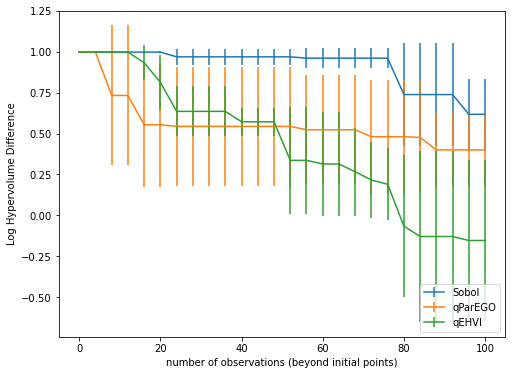

In [11]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
log_hv_difference_qparego = np.log10(10 - np.asarray(hvs_qparego_all))
log_hv_difference_qehvi = np.log10(10 - np.asarray(hvs_qehvi_all))
log_hv_difference_rnd = np.log10(10 - np.asarray(hvs_random_all))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, log_hv_difference_rnd.mean(axis=0), yerr=ci(log_hv_difference_rnd), label="Sobol", linewidth=1.5)
ax.errorbar(iters, log_hv_difference_qparego.mean(axis=0), yerr=ci(log_hv_difference_qparego), label="qParEGO", linewidth=1.5)
ax.errorbar(iters, log_hv_difference_qehvi.mean(axis=0), yerr=ci(log_hv_difference_qehvi), label="qEHVI", linewidth=1.5)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='Log Hypervolume Difference')
ax.legend(loc="lower right")

#### plot the observations colored by iteration

To examine optimization process from another perspective, we plot the collected observations under each algorithm where the color corresponds to the BO iteration at which the point was collected. The plot on the right for $q$EHVI shows that the $q$EHVI quickly identifies the pareto front and most of its evaluations are very close to the pareto front. $q$ParEGO also identifies has many observations close to the pareto front, but relies on optimizing random scalarizations, which is a less principled way of optimizing the pareto front compared to $q$EHVI, which explicitly attempts focuses on improving the pareto front. Sobol generates random points and has few points close to the pareto front

Text(0.5, 1.0, 'Iteration')

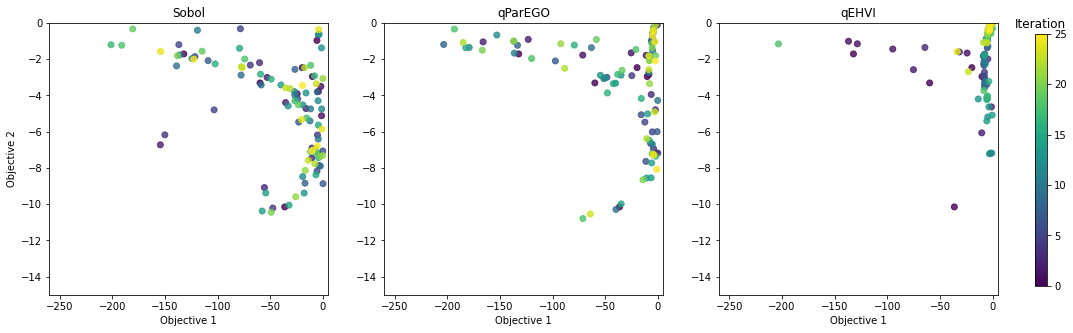

In [12]:
from matplotlib.cm import ScalarMappable
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
algos = ["Sobol", "qParEGO", "qEHVI"]
cm = plt.cm.get_cmap('viridis')

batch_number = torch.cat([torch.zeros(6), torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]).numpy()
for i, train_obj in enumerate((train_obj_random, train_obj_qparego, train_obj_qehvi)):
    sc = axes[i].scatter(train_obj[:, 0].cpu().numpy(), train_obj[:,1].cpu().numpy(), c=batch_number, alpha=0.8)
    axes[i].set_title(algos[i])
    axes[i].set_xlabel("Objective 1")
    axes[i].set_xlim(-260, 5)
    axes[i].set_ylim(-15, 0)
axes[0].set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")